In [220]:
from nltk.corpus import wordnet as wn
import csv
import nltk
import math

from scipy.stats import spearmanr, pearsonr


max_depth = max(len(hyp_path) for synset in wn.all_synsets() for hyp_path in synset.hypernym_paths())

print("max_depth", max_depth)

max_depth 20


In [221]:
def read_wordsim353():
    wordsim353 = []
    with open('./utils/wordsim353.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            wordsim353.append((row['Word 1'], row['Word 2'], float(row['Human (mean)'])))
    return wordsim353 

In [222]:
def depth(synset):
    path = []
    while synset:
        path.append(synset)
        synset = synset.hypernyms()

In [223]:
def myget_depth(synset):
    path = []
    if (len(synset.hypernyms()) == 0):
        return 1, [synset]
    print(synset, len(synset.hypernyms()))
    max = 0
    for hyp in synset.hypernyms():
        
        print( '\thypon: ' + str(hyp))
        pathmax, subpath = myget_depth(hyp)

        print(pathmax, subpath)

        if (pathmax > max):
            max = pathmax
            path = [synset] + subpath
            print(path)
    return max + 1, path

In [224]:
""" a function that calculate the lowest common anchestor in a tree with multiple ancherstor for node """
def lowest_common_ancestor(node1, node2):
    # Get all ancestors for both nodes
    ancestors1 = find_ancestors(node1)
    ancestors2 = find_ancestors(node2)
    
    # Find the common ancestors
    common_ancestors = ancestors1.intersection(ancestors2)
    
    if not common_ancestors:
        return None  # No common ancestor found
    
    # If we have multiple common ancestors, select the one that is closest to either node1 or node2.
    # Assuming that we want to find the ancestor with the smallest depth in the tree.
    lca = None
    min_depth = float('inf')
    
    for ancestor in common_ancestors:
        depth = 0
        current = ancestor
        
        # Calculate depth by going up to the root
        while current:
            if current in ancestors1 or current in ancestors2:
                break
            depth += 1
            current = current.parents[0] if current.parents else None
        
        if depth < min_depth:
            min_depth = depth
            lca = ancestor
            
    return lca


In [249]:

def get_hypernym_paths(synset):
    """Risalire la gerarchia degli hypernyms fino alla radice."""
    paths = [[synset]]
    
    while True:
        new_paths = []
        for path in paths:
            current = path[-1] # take the last element of the path
            hypernyms = current.hypernyms()
            if not hypernyms: # if no hypernym is found, we reached the root
                new_paths.append(path)
            else:
                for hypernym in hypernyms: # add all hypernyms to the path
                    new_paths.append(path + [hypernym])
        
        if new_paths == paths:  # Nessun hypernym trovato, siamo alla radice
            break
        paths = new_paths
    
    return paths

def find_lowest_common_ancestor(synset1, synset2):
    """Trovare l'antenato comune più basso tra due synset."""
    paths1 = get_hypernym_paths(synset1)
    paths2 = get_hypernym_paths(synset2)

    """ 
    low
    deph 1
    deph 2
    deplcs
    i = 0
     scorro il primo   
        set
        j=0
        scorro il secondo
            se ttrovo un elemento in comune
                se è minore del low
                    setto low
                    setto deph1
                    setto deph2
       """
    lowest_common_ancestor = None
    deph_lowest_common_ancestor = None
    deph1 = None
    deph2 = None

    for path1 in paths1:
        ##print("path1:", path1)
        ancestors1 = set(path1)
        # print(ancestors1)
        for path2 in paths2:
           #print("path2:", path2)
            for i in range(len(path2)):
                syn = path2[i]
                if syn in ancestors1:
                    lca = syn
                    deph_lca = len(path2) - i
                
                    if (not lowest_common_ancestor or deph_lca > deph_lowest_common_ancestor) and len(path1) >= deph_lca and  len(path2)  >= deph_lca:
                        lowest_common_ancestor = lca
                        deph_lowest_common_ancestor = deph_lca
                        # print("path1:", path1)
                        # print("path2:", path2)

                        deph1 = len(path1) #TODO: maybe -1
                        deph2 = len(path2) #TODO: maybe -1

                        #print("deph1", deph1, "deph2", deph2, "deph_lca", deph_lowest_common_ancestor, "lca", lowest_common_ancestor)
                    

    return lowest_common_ancestor, deph_lowest_common_ancestor, deph1, deph2

# Esempio di utilizzo:
synset1 = wn.synset('football.n.01')
synset2 = wn.synset('soccer.n.01')


# lca = find_lowest_common_ancestor(synset1, synset2)
# print("L'antenato comune più basso è:", lca)



In [226]:
def wup_similarity(synset1, synset2):
    _, deph_lca, deph1, deph2 = find_lowest_common_ancestor(synset1, synset2)
    if(deph_lca == None):
        return 0
    return (2 * deph_lca) / (deph1 + deph2)

In [227]:
def sph_similarity(synset1, synset2):
    _, deph_lca, deph1, deph2 = find_lowest_common_ancestor(synset1, synset2)
    if(deph_lca == None):
        return 0
    len = deph1 - deph_lca + deph2 - deph_lca

    return (2 * max_depth - len ) / (2 * max_depth)

In [251]:
def lch_similarity(synset1, synset2):
    _, deph_lca, deph1, deph2 = find_lowest_common_ancestor(synset1, synset2)
    if(deph_lca == None):
        return 0
    len = deph1 - deph_lca + deph2 - deph_lca
    #print(synset1, synset2, deph1, deph2, deph_lca, len)
    return (- math.log((len + 1) / ((2 * max_depth) + 1))) / math.log(2 * max_depth + 1) 

In [229]:
def find_lowest_common_ancestor_for_words(word1, word2):
    wup_sim=0
    sph_sim=0
    lch_sim = 0
    for syn1 in wn.synsets(word1):
        for syn2 in wn.synsets(word2):
            wup_score = wup_similarity(syn1, syn2)
            sph_score = sph_similarity(syn1, syn2)
            lch_score = lch_similarity(syn1, syn2)
            if wup_score > wup_sim:
                wup_sim = wup_score
            if sph_score > sph_sim:
                sph_sim = sph_score
            if lch_score > lch_sim:
                lch_sim = lch_score
    return wup_sim, sph_sim, lch_sim

In [253]:
wup_similarities = [] # for the pearson and spearman correlation values between 0 and 1
target_similarities = [] # for the pearson and spearman correlation values between 0 and 10
lch_similarities = []
path_similarities = []

wordsim353 = read_wordsim353()


for word1, word2, target in wordsim353: 
    print(word1, word2)
    wup_sim, sph_sim, lch_sim = find_lowest_common_ancestor_for_words(word1, word2)
    target_similarities.append(target)
    wup_similarities.append(wup_sim  * 10)
    path_similarities.append(sph_sim * 10)
    lch_similarities.append(lch_sim  * 10)

    print(f"La similarità tra '{word1}' e '{word2}' è:", wup_sim, sph_sim, lch_sim, target)


pearsonwup = pearsonr(wup_similarities, target_similarities)
pearsonlch = pearsonr(lch_similarities, target_similarities)
pearsonpath = pearsonr(path_similarities, target_similarities)

spearmanwup = spearmanr(wup_similarities, target_similarities)
spearmanlch = spearmanr(lch_similarities, target_similarities)
spearmanpath = spearmanr(path_similarities, target_similarities)


print('Pearson for Wu & Palmer\n{}'.format(pearsonwup))
print('Pearson for Leacock & Chodorow\n{}'.format(pearsonlch))
print('Pearson for Path\n{}'.format(pearsonpath))

print('Spearman for Wu & Palmer\n{}'.format(spearmanwup))
print('Spearman for Leacock & Chodorow\n{}'.format(spearmanlch))
print('Spearman for Path\n{}'.format(spearmanpath))

love sex
La similarità tra 'love' e 'sex' è: 0.9230769230769231 0.975 0.8133475887610566 6.77
tiger cat
La similarità tra 'tiger' e 'cat' è: 0.9655172413793104 0.975 0.8133475887610566 7.35
tiger tiger
La similarità tra 'tiger' e 'tiger' è: 1.0 1.0 1.0 10.0
book paper
La similarità tra 'book' e 'paper' è: 0.875 0.95 0.7041629275170908 7.46
computer keyboard
La similarità tra 'computer' e 'keyboard' è: 0.8235294117647058 0.925 0.6266951775221132 7.62
computer internet
La similarità tra 'computer' e 'internet' è: 0.631578947368421 0.825 0.44004276628316985 7.58
plane car
La similarità tra 'plane' e 'car' è: 0.7272727272727273 0.85 0.47600043459443225 5.77
train car
La similarità tra 'train' e 'car' è: 0.7368421052631579 0.875 0.5175105162781473 6.31
telephone communication
La similarità tra 'telephone' e 'communication' è: 0.16666666666666666 0.75 0.35428874686510764 7.5
television radio
La similarità tra 'television' e 'radio' è: 0.9090909090909091 0.95 0.7041629275170908 6.77
media rad

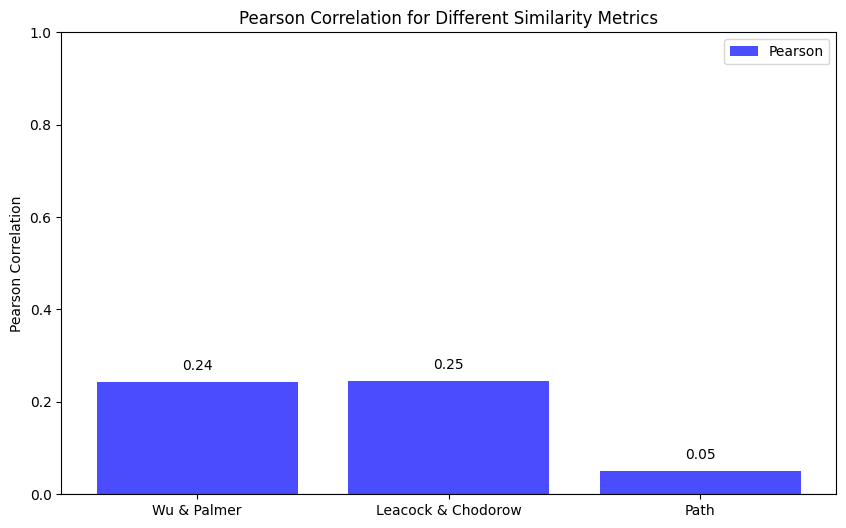

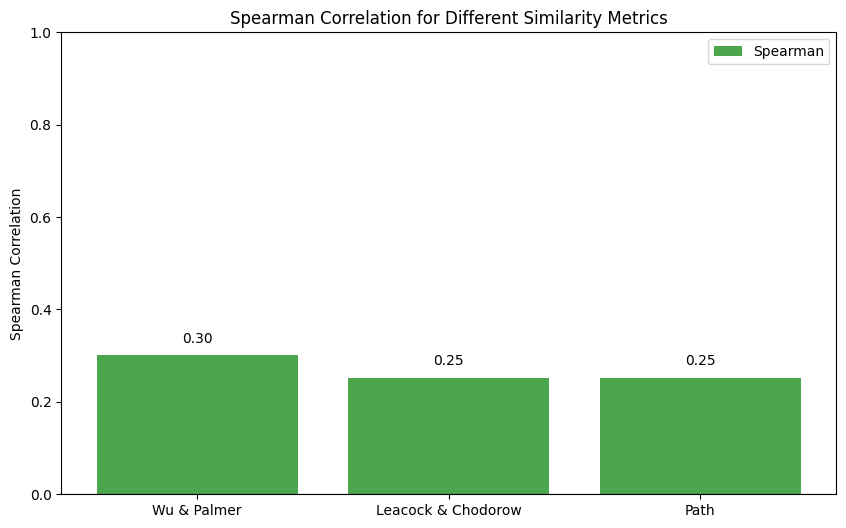

In [255]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Dati per il grafico
metrics = ['Wu & Palmer', 'Leacock & Chodorow', 'Path']
pearson_values = [pearsonwup[0], pearsonlch[0], pearsonpath[0]]
spearman_values = [spearmanwup[0], spearmanlch[0], spearmanpath[0]]

# Creazione del grafico per le correlazioni Pearson
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(metrics, pearson_values, color='blue', alpha=0.7, label='Pearson')
ax.set_ylim(0, 1)
ax.set_ylabel('Pearson Correlation')
ax.set_title('Pearson Correlation for Different Similarity Metrics')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()

# Aggiunta dei valori sopra le barre
for i, v in enumerate(pearson_values):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()

# Creazione del grafico per le correlazioni Spearman
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(metrics, spearman_values, color='green', alpha=0.7, label='Spearman')
ax.set_ylim(0, 1)
ax.set_ylabel('Spearman Correlation')
ax.set_title('Spearman Correlation for Different Similarity Metrics')
ax.axhline(0, color='black', linewidth=0.8)
ax.legend()

# Aggiunta dei valori sopra le barre
for i, v in enumerate(spearman_values):
    ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')

plt.show()


In [ ]:
def print_hypernyms(synset):
    hyp = synset.hypernyms()
    for h in hyp:
        print(h)
        print_hypernyms(h)
        
for syn in wn.synsets('telephone'):
    print_hypernyms(syn)
    print('---')

Synset('electronic_equipment.n.01')
Synset('equipment.n.01')
Synset('instrumentality.n.03')
Synset('artifact.n.01')
Synset('whole.n.02')
Synset('object.n.01')
Synset('physical_entity.n.01')
Synset('entity.n.01')
---
Synset('telecommunication.n.01')
Synset('medium.n.01')
Synset('instrumentality.n.03')
Synset('artifact.n.01')
Synset('whole.n.02')
Synset('object.n.01')
Synset('physical_entity.n.01')
Synset('entity.n.01')
---
Synset('telecommunicate.v.01')
Synset('communicate.v.02')
Synset('interact.v.01')
Synset('act.v.01')
---
